In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pickle
import numpy as np

import crflux.models as pm

from MCEq.data import InteractionCrossSections
from MCEq.core import MCEqRun
import  mceq_underground_helpers_oneregion_threshold as helper
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [2]:
def sl_depth(d,angle):
    return d/np.cos(np.deg2rad(angle))

In [3]:
plot_dir = '/hetghome/khymon/Plots/cs-analysis/'


X = helper.slant_depths[2:-1:4]

In [4]:
cs_p_values = [1.0] #[0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]  # List of cross-section values: pion-air
cs_k_values = [1.00,1.01]
cs_pr_values = [1.00]
ptype_values = [2212] 
season_values = ["jan", "apr", "jul"]  #  seasons
e0_values = [2.05,2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85]
e1_values = [2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85,4.95,5.05]
e_center = e0_values + np.ones(len(e0_values))*0.1
pairwise = True


helper.initialize_flux_dicts(
        ptype_values, cs_p_values, cs_k_values, cs_pr_values, e0_values, e1_values if 'e1_values' in locals() else [None], pairwise=pairwise
) 

helper.some_function_that_uses_angles()
angles = helper.angles

2.05 2.25
helper script 2.05 2.25 1.0 1.01 1.0
2.15 2.35
helper script 2.15 2.35 1.0 1.01 1.0
2.25 2.45
helper script 2.25 2.45 1.0 1.01 1.0
2.35 2.55
helper script 2.35 2.55 1.0 1.01 1.0
2.45 2.65
helper script 2.45 2.65 1.0 1.01 1.0
2.55 2.75
helper script 2.55 2.75 1.0 1.01 1.0
2.65 2.85
helper script 2.65 2.85 1.0 1.01 1.0
2.75 2.95
helper script 2.75 2.95 1.0 1.01 1.0
2.85 3.05
helper script 2.85 3.05 1.0 1.01 1.0
2.95 3.15
helper script 2.95 3.15 1.0 1.01 1.0
3.05 3.25
helper script 3.05 3.25 1.0 1.01 1.0
3.15 3.35
helper script 3.15 3.35 1.0 1.01 1.0
3.25 3.45
helper script 3.25 3.45 1.0 1.01 1.0
3.35 3.55
helper script 3.35 3.55 1.0 1.01 1.0
3.45 3.65
helper script 3.45 3.65 1.0 1.01 1.0
3.55 3.75
helper script 3.55 3.75 1.0 1.01 1.0
3.65 3.85
helper script 3.65 3.85 1.0 1.01 1.0
3.75 3.95
helper script 3.75 3.95 1.0 1.01 1.0
3.85 4.05
helper script 3.85 4.05 1.0 1.01 1.0
3.95 4.15
helper script 3.95 4.15 1.0 1.01 1.0
4.05 4.25
helper script 4.05 4.25 1.0 1.01 1.0
4.15 4.35
hel

In [5]:
cs_p = 1.0
cs_k = 1.01
cs_pr = 1.0
angle = 0.0
season = "apr"

In [6]:
def get_log_y(X, angle,cs_p,cs_k,e0,e1,season,threshold):
    log_y = np.log10(1e4*helper.mult_dist(X,
                            angle,
                            pm.GlobalSplineFitBeta(),"yields_" + season,
                            2212,
                            cs_p, cs_k,cs_pr,e0,e1,
                            norm=False,threshold=threshold#))[0]
                        ) / helper.rates(X, angle, season, 2212, cs_p, cs_k,cs_pr, e0,e1,threshold))

    return log_y

In [7]:
def get_derivative(x_log, log_y):

    deriv_low = (log_y[19] - log_y[1])/(np.log10(x_log[19])-np.log10(x_log[1])) 
    deriv_high = (log_y[99] - log_y[59])/(np.log10(x_log[99])-np.log10(x_log[59])) 

    return np.array([deriv_low, deriv_high])

In [8]:
x_log = np.log10(helper.n_mu_vec)

In [9]:
deriv_mod_15_500 =np.ndarray(shape=(len(e0_values),2))
deriv_mod_35_500 =np.ndarray(shape=(len(e0_values),2))
for en in range(len(e0_values)):
    logy_15_500 = get_log_y(X[0], angle, cs_p, cs_k ,e0_values[en],e1_values[en],season,threshold=500)
    deriv_mod_15_500[en] = get_derivative(x_log, logy_15_500)

    logy_35_500 = get_log_y(X[1], angle, cs_p, cs_k ,e0_values[en],e1_values[en],season,threshold=500)
    deriv_mod_35_500[en] = get_derivative(x_log, logy_35_500)

y_log_def_15_500 = get_log_y(X[0], angle, 1.0, 1.0 ,2.05,"inf",season,threshold=500)
deriv_def_15_500 = get_derivative(x_log, y_log_def_15_500)

y_log_def_35_500 = get_log_y(X[1], angle, 1.0, 1.0 ,2.05,"inf",season,threshold=500)
deriv_def_35_500 = get_derivative(x_log, y_log_def_35_500)

In [10]:
deriv_mod_15 =np.ndarray(shape=(len(e0_values),2))
deriv_mod_35 =np.ndarray(shape=(len(e0_values),2))
for en in range(len(e0_values)):
    logy_15 = get_log_y(X[0], angle, cs_p, cs_k ,e0_values[en],e1_values[en],season,threshold=0.0001)
    deriv_mod_15[en] = get_derivative(x_log, logy_15)

    logy_35 = get_log_y(X[1], angle, cs_p, cs_k ,e0_values[en],e1_values[en],season,threshold=0.0001)
    deriv_mod_35[en] = get_derivative(x_log, logy_35)

y_log_def_15 = get_log_y(X[0], angle, 1.0, cs_k ,2.05,"inf",season,threshold=0.0001)
deriv_def_15 = get_derivative(x_log, y_log_def_15)

y_log_def_35 = get_log_y(X[1], angle, 1.0, cs_k ,2.05,"inf",season,threshold=0.0001)
deriv_def_35 = get_derivative(x_log, y_log_def_35)

In [11]:
deriv_def_15/deriv_def_15_500

array([0.90282556, 1.06550868])

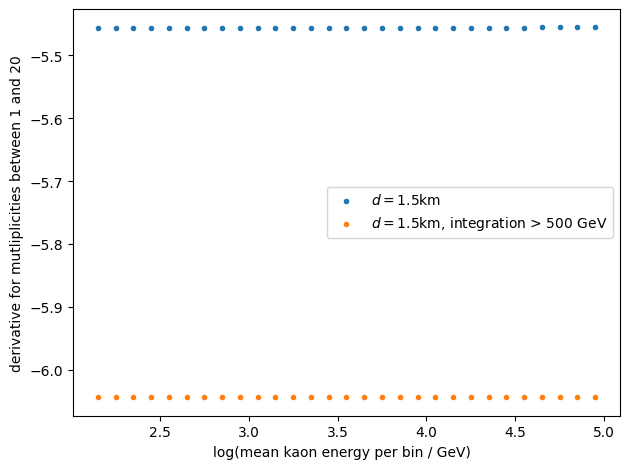

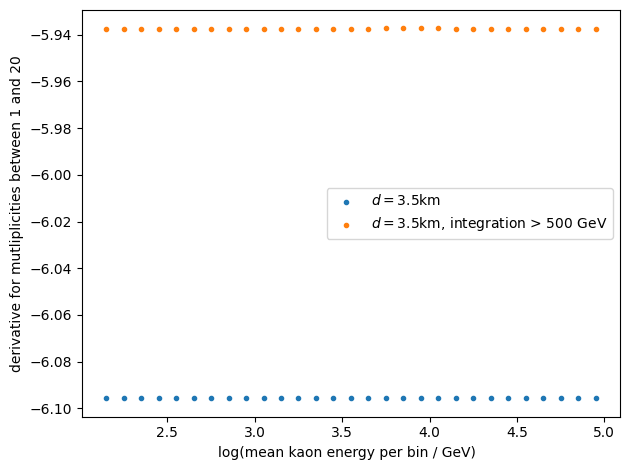

<Figure size 640x480 with 0 Axes>

In [12]:
plt.scatter(e_center,deriv_mod_15[:,0],label="$d=1.5$km",marker='.')
plt.scatter(e_center,deriv_mod_15_500[:,0],label="$d=1.5$km, integration > 500 GeV",marker='.')
#plt.plot([2.05,5],[deriv_def_15[0],deriv_def_15[0]],color='black')
plt.ylabel('derivative for mutliplicities between 1 and 20')
plt.xlabel('log(mean kaon energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_lowregion_ebin_d15km_integrationthres.png')
plt.show()
plt.clf()

plt.scatter(e_center,deriv_mod_35[:,0],label="$d=3.5$km",marker='.')
plt.scatter(e_center,deriv_mod_35_500[:,0],label="$d=3.5$km, integration > 500 GeV",marker='.')
#plt.plot([2.05,5],[deriv_def_35[0],deriv_def_35[0]],color='black')
plt.ylabel('derivative for mutliplicities between 1 and 20')
plt.xlabel('log(mean kaon energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_lowregion_ebin_d35km_integrationthres.png')
plt.show()
plt.clf()

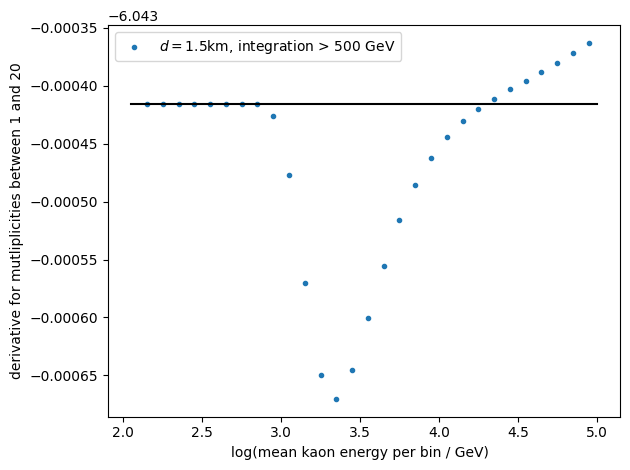

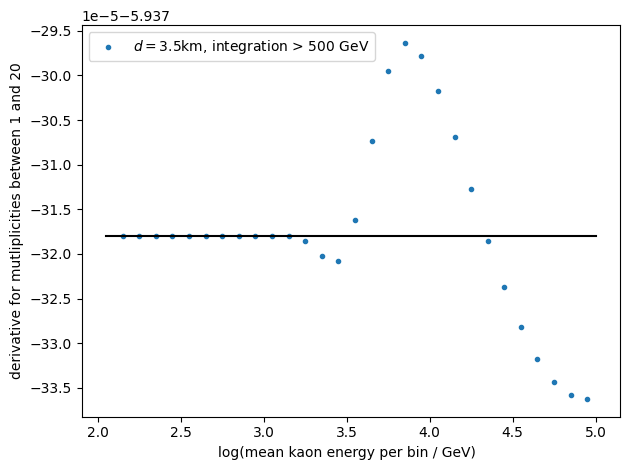

<Figure size 640x480 with 0 Axes>

In [13]:
#plt.scatter(e_center,deriv_mod_15[:,0],label="$d=1.5$km",marker='.')
plt.scatter(e_center,deriv_mod_15_500[:,0],label="$d=1.5$km, integration > 500 GeV",marker='.')
plt.plot([2.05,5],[deriv_def_15_500[0],deriv_def_15_500[0]],color='black')
plt.ylabel('derivative for mutliplicities between 1 and 20')
plt.xlabel('log(mean kaon energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_lowregion_ebin_d15km_integrationthres500GeV.png')
plt.show()
plt.clf()

#plt.scatter(e_center,deriv_mod_35[:,0],label="$d=3.5$km",marker='.')
plt.scatter(e_center,deriv_mod_35_500[:,0],label="$d=3.5$km, integration > 500 GeV",marker='.')
plt.plot([2.05,5],[deriv_def_35_500[0],deriv_def_35_500[0]],color='black')
plt.ylabel('derivative for mutliplicities between 1 and 20')
plt.xlabel('log(mean kaon energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_lowregion_ebin_d35km_integrationthres500GeV.png')
plt.show()
plt.clf()

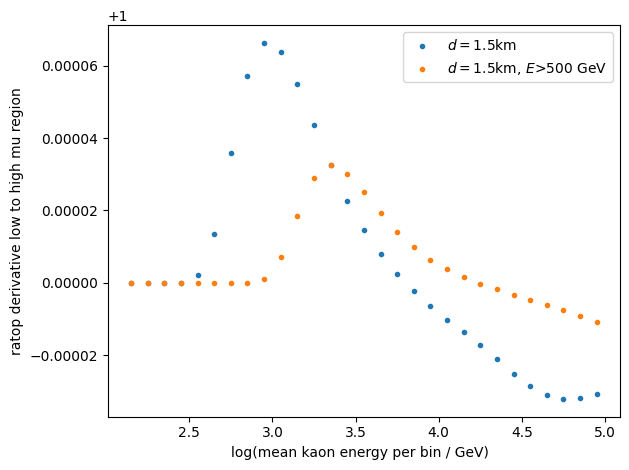

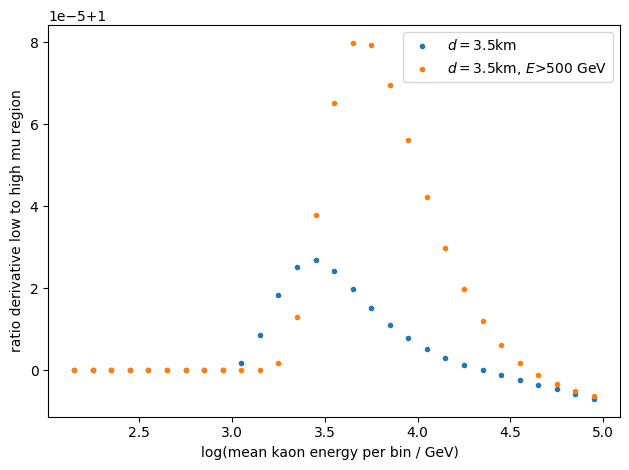

<Figure size 640x480 with 0 Axes>

In [14]:
def_ratio_15 = np.ones(len(e_center))* (deriv_def_15[0]/deriv_def_15[1])
def_ratio_35 = np.ones(len(e_center))* (deriv_def_35[0]/deriv_def_35[1])

def_ratio_15_500 = np.ones(len(e_center))* (deriv_def_15_500[0]/deriv_def_15_500[1])
def_ratio_35_500 = np.ones(len(e_center))* (deriv_def_35_500[0]/deriv_def_35_500[1])


plt.scatter(e_center,(deriv_mod_15[:,0]/deriv_mod_15[:,1])/def_ratio_15,label="$d=1.5$km",marker='.')
plt.scatter(e_center,(deriv_mod_15_500[:,0]/deriv_mod_15_500[:,1])/def_ratio_15_500,label="$d=1.5$km, $E$>500 GeV",marker='.')
plt.ylabel('ratop derivative low to high mu region')
plt.xlabel('log(mean kaon energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_ratio-to-def_ebin_d15_threshold.png')
plt.show()
plt.clf()


plt.scatter(e_center,(deriv_mod_35[:,0]/deriv_mod_35[:,1])/def_ratio_35,label="$d=3.5$km",marker='.')
plt.scatter(e_center,(deriv_mod_35_500[:,0]/deriv_mod_35_500[:,1])/def_ratio_35_500,label="$d=3.5$km, $E$>500 GeV",marker='.')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('log(mean kaon energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_ratio-to-def_ebin_d35_threshold.png')
plt.show()
plt.clf()

In [15]:
sl = sl_depth(1.5,angles)

deriv_mod_sl =np.ndarray(shape=(len(sl),len(e0_values),2))
deriv_def_sl = np.ndarray(shape=(len(sl),2))

deriv_mod_sl_500 =np.ndarray(shape=(len(sl),len(e0_values),2))
deriv_def_sl_500 = np.ndarray(shape=(len(sl),2))

for s in range(len(sl)):    

    y_log_def_sl = get_log_y(sl[s], angle, 1.0, 1.0 ,2.05,"inf",season,threshold=0.0001)
    deriv_def_sl[s] = get_derivative(x_log, y_log_def_sl)

    y_log_def_sl_500 = get_log_y(sl[s], angle, 1.0, 1.0 ,2.05,"inf",season,threshold=500)
    deriv_def_sl_500[s] = get_derivative(x_log, y_log_def_sl_500)

    for en in range(len(e0_values)):
        logy_mod_500 = get_log_y(sl[s], angle, 1.0, cs_k ,e0_values[en],e1_values[en],season,threshold=500)
        deriv_mod_sl_500[s][en] = get_derivative(x_log, logy_mod_500)


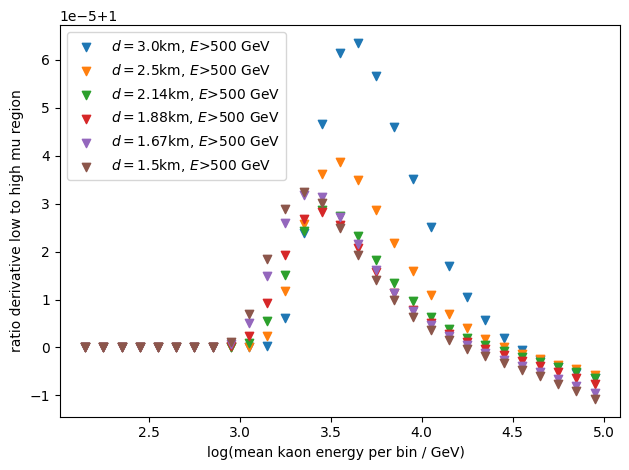

<Figure size 640x480 with 0 Axes>

In [16]:
for s in range(len(sl)):
    def_ratio_sl = np.ones(len(e_center))* (deriv_def_sl[s][0]/deriv_def_sl[s][1])
    def_ratio_sl_500 = np.ones(len(e_center))* (deriv_def_sl_500[s][0]/deriv_def_sl_500[s][1])

    #plt.scatter(e_center,(deriv_mod_sl[s,:,0]/deriv_mod_sl[s,:,1])/def_ratio_sl,label="$d=$" +str(np.round(sl[s],decimals=2)) + "km",marker='.')
    plt.scatter(e_center,(deriv_mod_sl_500[s,:,0]/deriv_mod_sl_500[s,:,1])/def_ratio_sl_500,label="$d=$" +str(np.round(sl[s],decimals=2)) + "km, $E$>500 GeV",marker='v')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('log(mean kaon energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_ratio-to-def_ebin_slantdepth_threshold.png')
plt.show()
plt.clf()

Little smaller compared to all muons

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1121914/3108126162.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$E_{\mu}\geq $ 500 GeV')
/tmp/ipykernel_1121914/3108126162.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$E_{\mu}\geq $ 500 GeV')
/tmp/ipykernel_1121914/3108126162.py:38: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$E_{\mu}\geq $ 500 GeV')
/tmp/ipykernel_1121914/3108126162.py:53: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$E_{\mu}\geq $ 500 GeV'

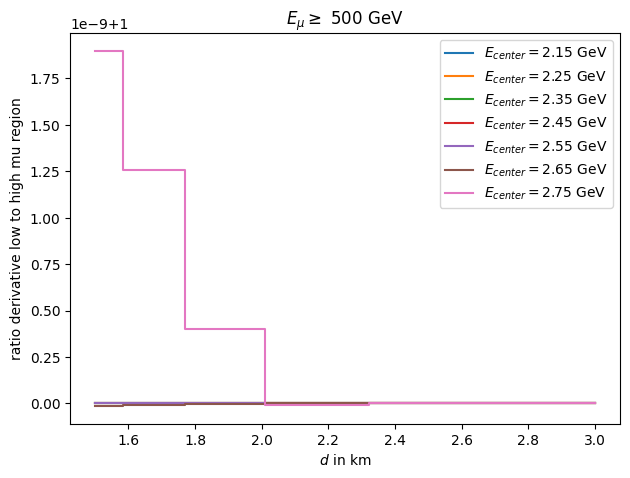

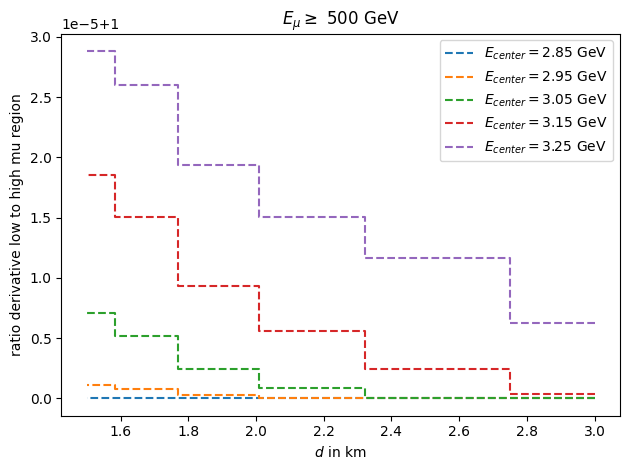

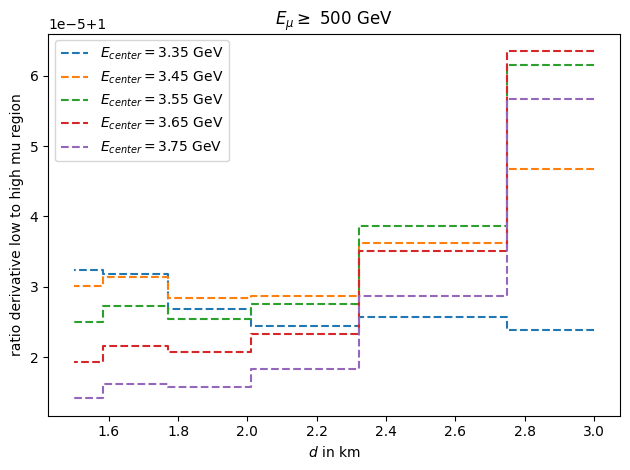

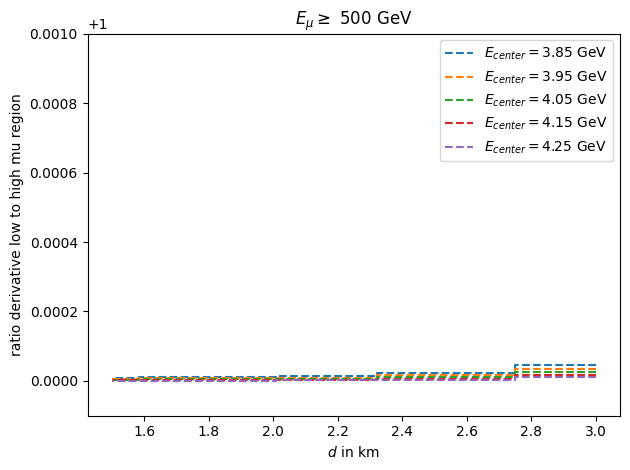

<Figure size 640x480 with 0 Axes>

In [17]:

def_ratio_sl_500 = np.ones(len(sl))* (deriv_def_sl_500[:,0]/deriv_def_sl_500[:,1])

for en in range(len(e_center[0:7])):
    
    plt.plot(sl,(deriv_mod_sl_500[:,en,0]/deriv_mod_sl_500[:,en,1])/def_ratio_sl_500,label="$E_{center}=$" + str(np.round(e_center[en],decimals=2)) + " GeV",drawstyle='steps-mid')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')


#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.title('$E_{\mu}\geq $ 500 GeV')
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin1-7_threshold.png')
plt.show()
plt.clf()

for en in range(len(e_center[0:5])):
    
    plt.plot(sl,(deriv_mod_sl_500[:,en+7,0]/deriv_mod_sl_500[:,en+7,1])/def_ratio_sl_500,label="$E_{center}=$" + str(np.round(e_center[en+7],decimals=2)) + " GeV",drawstyle='steps-mid',ls='--')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')
plt.title('$E_{\mu}\geq $ 500 GeV')


#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin8-12_threshold.png')
plt.show()
plt.clf()

for en in range(len(e_center[0:5])):
    
    plt.plot(sl,(deriv_mod_sl_500[:,en+12,0]/deriv_mod_sl_500[:,en+12,1])/def_ratio_sl_500,label="$E_{center}=$" + str(np.round(e_center[en+12],decimals=2)) + " GeV",drawstyle='steps-mid',ls='--')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')
plt.title('$E_{\mu}\geq $ 500 GeV')

#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin12-17_threshold.png')
plt.show()
plt.clf()


for en in range(len(e_center[0:5])):
    
    plt.plot(sl,(deriv_mod_sl_500[:,en+17,0]/deriv_mod_sl_500[:,en+17,1])/def_ratio_sl_500,label="$E_{center}=$" + str(np.round(e_center[en+17],decimals=2)) + " GeV",drawstyle='steps-mid',ls='--')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')
plt.title('$E_{\mu}\geq $ 500 GeV')

plt.ylim([0.99990,1.0010])
#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin17-22_threshold.png')
plt.show()
plt.clf()

for en in range(len(e_center[0:5])):
    
    plt.plot(sl,(deriv_mod_sl_500[:,en+22,0]/deriv_mod_sl_500[:,en+22,1])/def_ratio_sl_500,label="$E_{center}=$" + str(np.round(e_center[en+22],decimals=2)) + " GeV",drawstyle='steps-mid',ls='--')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')
plt.title('$E_{\mu}\geq $ 500 GeV')

#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin22-27_threshold.png')

plt.ylim([0.99990,1.0010])
plt.clf()
plt.show()






<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1121914/3404975267.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$E_{\mu}\geq $ 500 GeV')


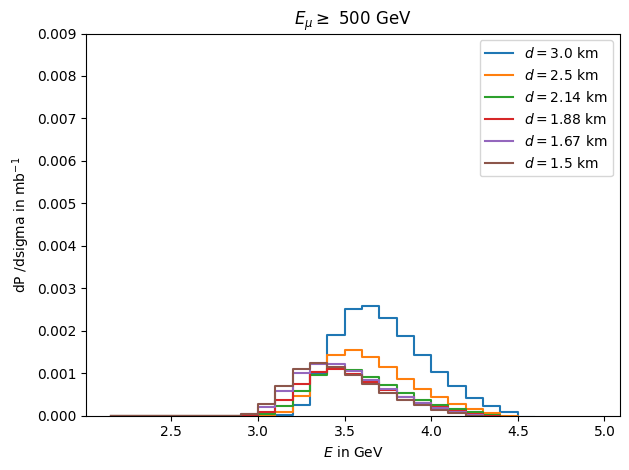

<Figure size 640x480 with 0 Axes>

In [18]:
# exchange energy and depth

delta_P_500 = (deriv_mod_sl_500[:,:,0]/deriv_mod_sl_500[:,:,1])-def_ratio_sl_500[:,np.newaxis]
dP_dsig_500 = delta_P_500/0.01

#plot for all energy bins
for d in range(len(sl)):
    plt.plot(e_center, dP_dsig_500[d,],label="$d=$" + str(np.round(sl[d],decimals=2)) + " km",drawstyle='steps-mid')
plt.ylabel('dP /dsigma in mb$^{-1}$')
plt.xlabel('$E$ in GeV')
plt.ylim([0.00,0.009])
plt.legend()
plt.title('$E_{\mu}\geq $ 500 GeV')
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_dPdsig_ebin_slantdepth_threshold.png')
plt.show()
plt.clf()

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1121914/1128751553.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$E_{\mu}\geq $ 500 GeV')
/tmp/ipykernel_1121914/1128751553.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(e_center, dP_dsig_500[d,:]**(-1),label="$d=$" + str(np.round(sl[d],decimals=2)) + " km",drawstyle='steps-mid')


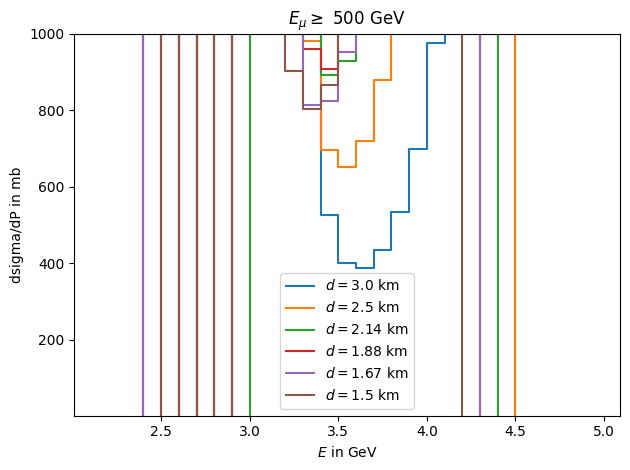

<Figure size 640x480 with 0 Axes>

In [19]:
# dsig dP

for d in range(len(sl)):
    plt.plot(e_center, dP_dsig_500[d,:]**(-1),label="$d=$" + str(np.round(sl[d],decimals=2)) + " km",drawstyle='steps-mid')
plt.ylabel('dsigma/dP in mb')
plt.xlabel('$E$ in GeV')
plt.ylim([1,1e3])
plt.legend()
plt.title('$E_{\mu}\geq $ 500 GeV')
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_dsigdP_ebin_slantdepth_threshold.png')
plt.show()
plt.clf()

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1121914/2616684731.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$E_{\mu}\geq $ 500 GeV')
/tmp/ipykernel_1121914/2616684731.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(e_center, dP_dsig_500[d,:]**(-1),label="$d=$" + str(np.round(sl[d],decimals=2)) + " km",drawstyle='steps-mid',ls='--')


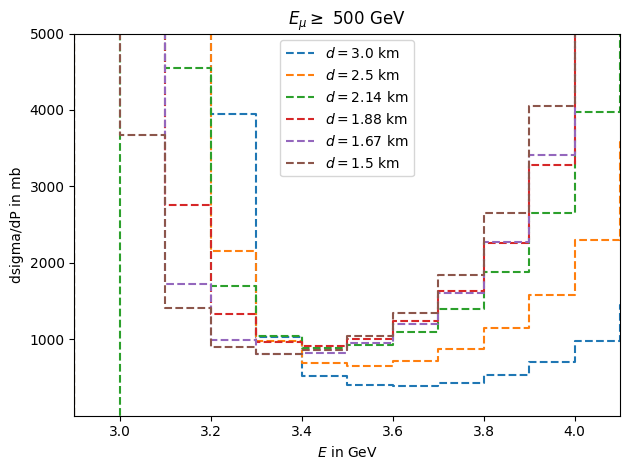

<Figure size 640x480 with 0 Axes>

In [20]:
for d in range(len(sl)):
    plt.plot(e_center, dP_dsig_500[d,:]**(-1),label="$d=$" + str(np.round(sl[d],decimals=2)) + " km",drawstyle='steps-mid',ls='--')
plt.ylabel('dsigma/dP in mb')
plt.xlabel('$E$ in GeV')
plt.ylim([1,5e3])
plt.xlim(2.9,4.1)
plt.legend()
plt.title('$E_{\mu}\geq $ 500 GeV')
plt.tight_layout()
plt.savefig(plot_dir + 'cs_k_energybintest_powerlawderiv_dsigdP_ebin_slantdepth_threshold_zoomed.png')
plt.show()
plt.clf()

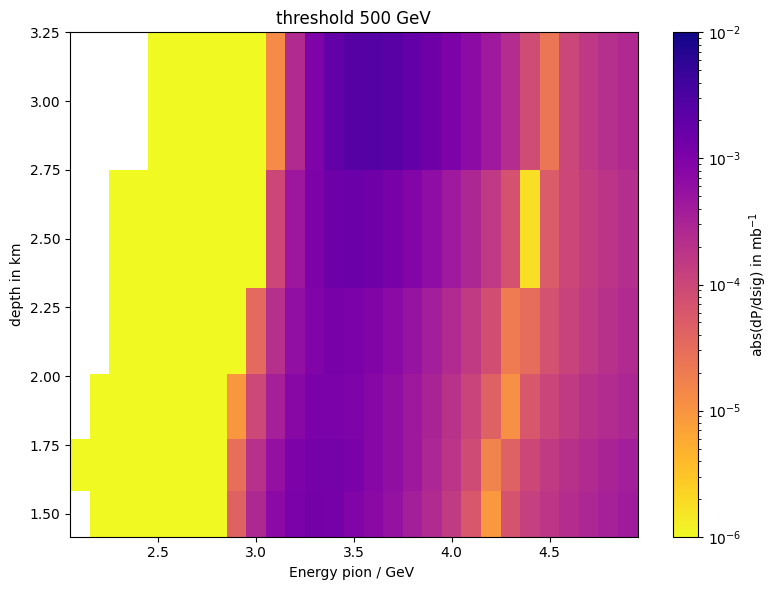

In [21]:
# 2D plot 

from matplotlib.colors import LogNorm
z = np.abs(dP_dsig_500)
z_min = 1e-6
z_max = 1e-2




# Calculate the first and last bin edges slant depth
depth_edges = np.zeros(len(sl) + 1)
depth_edges[0] = sl[0] - (sl[1] - sl[0]) / 2
depth_edges[-1] = sl[-1] + (sl[-1] - sl[-2]) / 2

e0_edges = e0_values + [4.95]

# Calculate edges for the interior bins
for i in range(1, len(sl)):
    depth_edges[i] = (sl[i-1] + sl[i]) / 2

plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_edges,depth_edges, z, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dP/dsig) in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('depth in km')
plt.title('threshold 500 GeV')
plt.tight_layout()


# Display the plot
plt.savefig(plot_dir + 'slope_param_2D_cs_k_dPdsig_d_energy_ebintest_threshold500gev.png')
plt.show()


/tmp/ipykernel_1121914/3610036200.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  z = np.abs(dP_dsig_500**(-1))


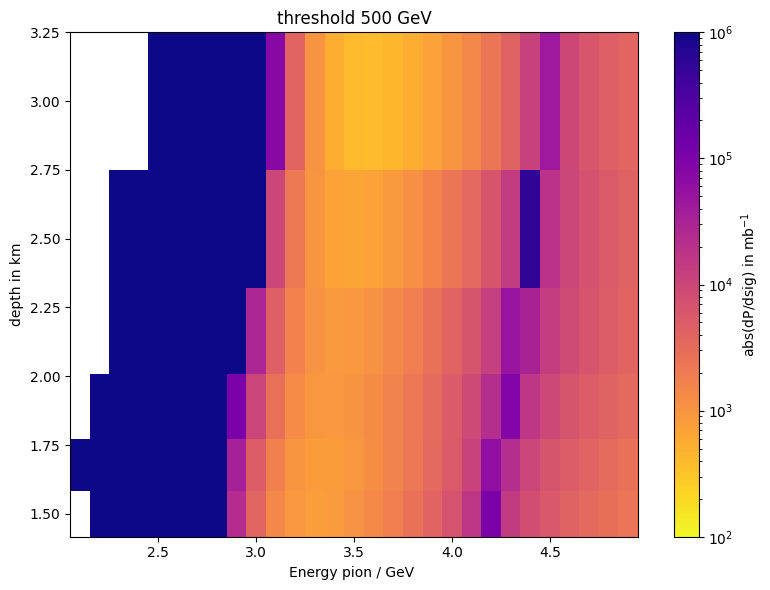

In [22]:
# 2D plot 

z = np.abs(dP_dsig_500**(-1))
z_min = 1e2
z_max = 1e6




# Calculate the first and last bin edges slant depth
depth_edges = np.zeros(len(sl) + 1)
depth_edges[0] = sl[0] - (sl[1] - sl[0]) / 2
depth_edges[-1] = sl[-1] + (sl[-1] - sl[-2]) / 2

e0_edges = e0_values + [4.95]

# Calculate edges for the interior bins
for i in range(1, len(sl)):
    depth_edges[i] = (sl[i-1] + sl[i]) / 2

plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_edges,depth_edges, z, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dP/dsig) in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('depth in km')
plt.title('threshold 500 GeV')


# Display the plot
plt.tight_layout()
plt.savefig(plot_dir + 'slope_param_2cs_k_D_ddsigdP_d_energy_ebintest_threshold500gev.png')
plt.show()





In [23]:
len(e0_values)

29

In [24]:
len(depth_edges)

7

In [25]:
len(sl)

6

In [26]:
len

<function len(obj, /)>